In [1]:
from keras import models, layers
from ngdlm import models as ngdlmodels
from ngdlm import utils as ngdlutils
from keras.datasets import mnist
import numpy as np

Using TensorFlow backend.
/Users/tristanbehrens/Development/python-venvs/venv-3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/tristanbehrens/Development/python-venvs/venv-3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Train- and test-data.

In [2]:
(x_input_train, _), (x_input_test, y_output_test) = mnist.load_data()
x_input_train = x_input_train.astype("float32").reshape(-1, 28, 28, 1) / 255.0
x_input_test = x_input_test.astype("float32").reshape(-1, 28, 28, 1) / 255.0

noise_factor = 0.5
x_input_train_noisy = x_input_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_input_train.shape) 
x_input_train_noisy = np.clip(x_input_train_noisy, 0., 1.)
x_input_test_noisy = x_input_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_input_test.shape) 
x_input_test_noisy = np.clip(x_input_test_noisy, 0., 1.)

print(x_input_train.shape)
print(x_input_test.shape)
print(x_input_train_noisy.shape)
print(x_input_test_noisy.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Render inputs and outputs.

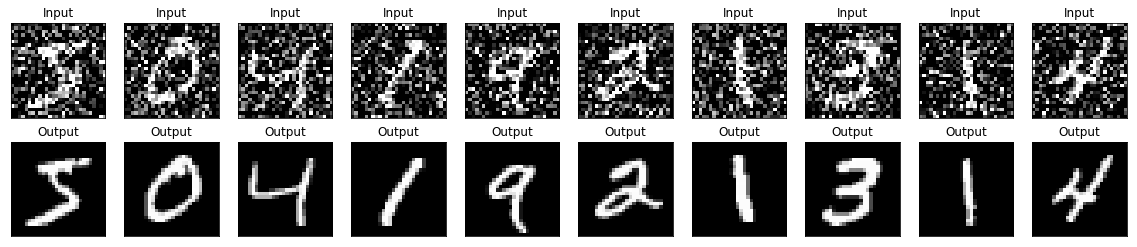

In [3]:
ngdlutils.render_image_inputs_outputs(x_input_train_noisy[:10], x_input_train[:10])

# Denoising autoencoder.

In [4]:
# Create the encoder.
encoder_input = layers.Input(shape=(28, 28, 1))
encoder_output = encoder_input
encoder_output = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_output)
encoder_output = layers.MaxPooling2D((2, 2), padding='same')(encoder_output)
encoder_output = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_output)
encoder_output = layers.MaxPooling2D((2, 2), padding='same')(encoder_output)
encoder = models.Model(encoder_input, encoder_output)

# Create the decoder.
decoder_input = layers.Input(shape=(7, 7, 32))
decoder_output = decoder_input
decoder_output = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoder_output)
decoder_output = layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoder_output)
decoder_output = layers.UpSampling2D((2, 2))(decoder_output)
decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder_output)
decoder = models.Model(decoder_input, decoder_output)

# Create the autoencoder.
ae = ngdlmodels.AE(encoder, decoder)
ae.compile(optimizer='adadelta', loss='binary_crossentropy')
ae.summary()

# Train.
print("Train...")
history = ae.fit(
        x_input_train_noisy, x_input_train,
        epochs=100,
        batch_size=128,
        validation_data=(x_input_test, x_input_test)
    )
    
# Evaluate.
print("Evaluate...")
loss = ae.evaluate(x_input_test_noisy, x_input_test)
print("Loss:", loss)

Encoder:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________
Decoder:
_________________________________________________________________
Layer (type)                 Output Shape              P

60000/60000 [==============================] - 126s 2ms/step - loss: 0.0952 - val_loss: 0.0754
Epoch 50/100
60000/60000 [==============================] - 128s 2ms/step - loss: 0.0951 - val_loss: 0.0748
Epoch 51/100
60000/60000 [==============================] - 125s 2ms/step - loss: 0.0950 - val_loss: 0.0747
Epoch 52/100
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0950 - val_loss: 0.0753
Epoch 53/100
60000/60000 [==============================] - 126s 2ms/step - loss: 0.0950 - val_loss: 0.0752
Epoch 54/100
60000/60000 [==============================] - 124s 2ms/step - loss: 0.0950 - val_loss: 0.0749
Epoch 55/100
60000/60000 [==============================] - 125s 2ms/step - loss: 0.0949 - val_loss: 0.0746
Epoch 56/100
60000/60000 [==============================] - 126s 2ms/step - loss: 0.0949 - val_loss: 0.0752
Epoch 57/100
60000/60000 [==============================] - 133s 2ms/step - loss: 0.0949 - val_loss: 0.0748
Epoch 58/100
60000/60000 [===============

# Visualizing denoising autoencoder.

Rendering history...


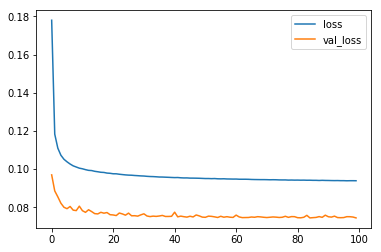

Rendering reconstructions...


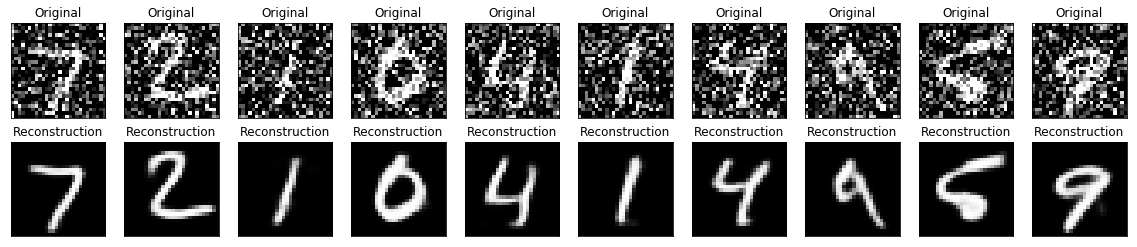

In [5]:
print("Rendering history...")
ngdlutils.render_history(history)

print("Rendering reconstructions...")
ngdlutils.render_image_reconstructions(ae, x_input_test_noisy[0:10])